In [241]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import normal as randn, multivariate_normal as randmn
import pandas as pd
import plotly.express as px
import matplotlib as mpl


In [242]:
%load_ext autoreload
%autoreload 2

from algorithms.score_based import *
from algorithms.contrastive_change_point import compute_test_stat_linear
from algorithms.fast_contrastive_change_point import compute_test_stat_ftal
from algorithms.kliep import compute_test_stat_kliep
from algorithms.m_statistic import compute_test_stat_mmd
from algorithms.cusum import compute_cusum
from consts import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [243]:
def reference_score(x):
    if isinstance(x, (int, float)):
        return np.array([-x]).reshape(-1, 1)
    return -x.reshape(-1, 1)

In [244]:
n=300
time = np.arange(1, n+1)
c = {'Score-based + linear': 'r', 'Score-based + quadratic': 'b', 'Fast contrastive + hermite': 'g', 'KLIEP': 'm', 'M-statistic': 'c', 'CUSUM':'y'}

In [245]:
dim = 1
n = 300
tau = 150

sigma = 0.3
eta = 1 / np.sqrt(np.arange(n) + 1)


S_dict = {}

np.random.seed(1)
X = sigma * randn(size=n).reshape((n, dim, 1))
X[tau:] += 3*sigma

# score based linear+ref
model = ChangePointDetector(d_dim=dim, lambda_=0.7, alpha=5e-2, basis=PolyBasis(1, dim), reference_score=reference_score)
model.run(X, eta)
S_dict['Score-based + linear'] = model.test_statistic

# score based quadratic
model = ChangePointDetector(d_dim=dim*2, lambda_=2, alpha=1e-4, basis=PolyBasis(2, dim))
model.run(X, eta)
S_dict['Score-based + quadratic'] = model.test_statistic

X = X.flatten()
# FALCON + hermite
p = 2
S_hermite, _ = compute_test_stat_ftal(X, p, beta=0.01, design='hermite')
S_dict['Fast contrastive + hermite'] = S_hermite

# kliep, m-stat, cusum
S_kliep, _ = compute_test_stat_kliep(X, window_size=20, sigma=1)
S_dict['KLIEP'] = S_kliep
S_mmd, _ = compute_test_stat_mmd(X, window_size=20, sigma=0.5)
S_dict['M-statistic'] = S_mmd
S_cusum, _ = compute_cusum(X)
S_dict['CUSUM'] = S_cusum



In [246]:
st_dict = {}

# score based linear+ref
model = ChangePointDetector(d_dim=dim, lambda_=0.7, alpha=5e-2, basis=PolyBasis(1, dim), reference_score=reference_score, threshold=threshold_1d_linear_03)
_, st_lin = model.run(X.reshape((n, dim, 1)), eta)
st_dict['Score-based + linear'] = st_lin
# score based quadratic
model = ChangePointDetector(d_dim=dim*2, lambda_=2, alpha=1e-4, basis=PolyBasis(2, dim), threshold=threshold_1d_quadratic_03)
_, st_q = model.run(X.reshape((n, dim, 1)), eta)
st_dict['Score-based + quadratic'] = st_q


# FALCON + hermite
p=2
_, st_ftal = compute_test_stat_ftal(X, p, beta=0.01, design='hermite', threshold=threshold_1d_ftal_hermite_03_beta001_p2)
st_dict['Fast contrastive + hermite'] = st_ftal

# kliep, m-stat, cusum
_, st_kliep = compute_test_stat_kliep(X, window_size=20, sigma=1, threshold=threshold_1d_kliep_03_20_1)
st_dict['KLIEP'] = st_kliep
_, st_mmd = compute_test_stat_mmd(X, window_size=20, sigma=0.5, threshold=threshold_1d_mmd_03_20_05)
st_dict['M-statistic'] = st_mmd
_, st_cusum = compute_cusum(X, threshold=threshold_1d_cusum_03)
st_dict['CUSUM'] = st_cusum

In [247]:
st_dict

{'Score-based + linear': 155,
 'Score-based + quadratic': 155,
 'Fast contrastive + hermite': 154,
 'KLIEP': 156,
 'M-statistic': 168,
 'CUSUM': 154}

In [248]:
df = pd.DataFrame(S_dict)
df.max()

Score-based + linear           14.348268
Score-based + quadratic       391.181480
Fast contrastive + hermite     77.207543
KLIEP                          17.406364
M-statistic                    87.844538
CUSUM                           7.807293
dtype: float64

In [249]:
S_dict['Score-based + quadratic'] /= 25
S_dict['Fast contrastive + hermite'] /= 4
S_dict['M-statistic'] /= 4


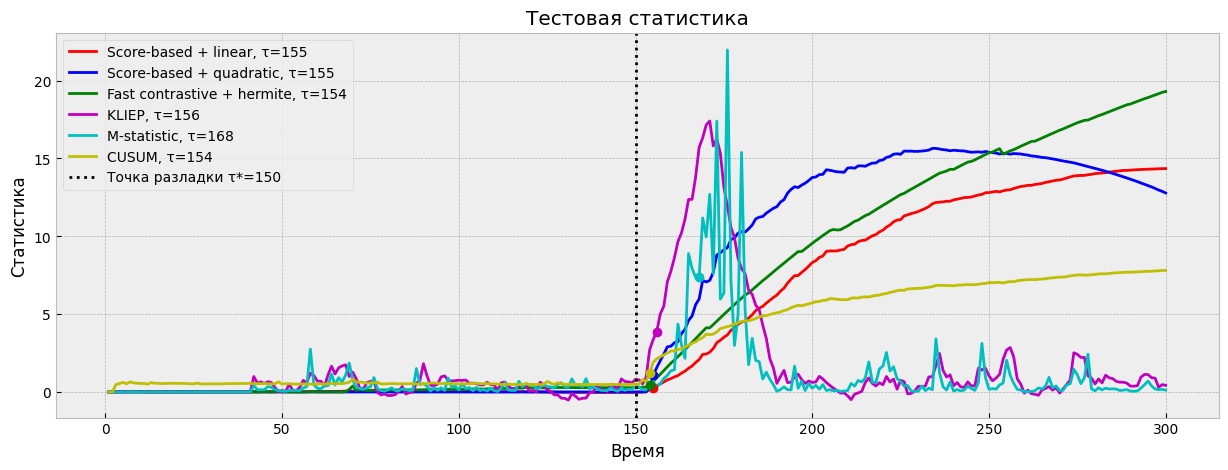

In [250]:
plt.figure(figsize=(15, 5))
plt.title('Тестовая статистика')
plt.xlabel('Время')
plt.ylabel('Статистика')
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("bmh")

for key, value in S_dict.items():
    plt.plot(time, value, label=f'{key}, τ={st_dict[key]}', color=c[key])

for key, value in st_dict.items():
    plt.plot([value], [S_dict[key][value-1]], 'o', color=c[key])


plt.axvline(tau, c='black', ls=':', label=f'Точка разладки τ*={tau}')
plt.legend()
plt.savefig('1d_mean_stats.png')
plt.show()

In [251]:
dim = 1
n = 300
tau = 150

sigma = 0.3
eta = 1 / np.sqrt(np.arange(n) + 1)


S_dict = {}

np.random.seed(1)
X = sigma * randn(size=n).reshape((n, dim, 1))
X[tau:] *= 3

# score based quadratic
model = ChangePointDetector(d_dim=dim*2, lambda_=2, alpha=1e-4, basis=PolyBasis(2, dim))
model.run(X, eta)
S_dict['Score-based + quadratic'] = model.test_statistic

X = X.flatten()
# FALCON + hermite
p = 3
S_hermite, _ = compute_test_stat_ftal(X, p, beta=0.1, design='hermite')
S_dict['Fast contrastive + hermite'] = S_hermite

# kliep, m-stat, cusum
S_kliep, _ = compute_test_stat_kliep(X, window_size=20, sigma=1)
S_dict['KLIEP'] = S_kliep
S_mmd, _ = compute_test_stat_mmd(X, window_size=20, sigma=0.5)
S_dict['M-statistic'] = S_mmd
S_cusum, _ = compute_cusum(X)
S_dict['CUSUM'] = S_cusum



In [252]:
st_dict = {}


# score based quadratic
model = ChangePointDetector(d_dim=dim*2, lambda_=2, alpha=1e-4, basis=PolyBasis(2, dim), threshold=threshold_1d_quadratic_03)
_, st_q = model.run(X.reshape((n, dim, 1)), eta)
st_dict['Score-based + quadratic'] = st_q

# FALCON + hermite
p=3
_, st_ftal = compute_test_stat_ftal(X, p, beta=0.1, design='hermite', threshold=threshold_1d_ftal_hermite_03_beta01_p3)
st_dict['Fast contrastive + hermite'] = st_ftal

# kliep, m-stat, cusum
_, st_kliep = compute_test_stat_kliep(X, window_size=20, sigma=1, threshold=threshold_1d_kliep_03_20_1)
st_dict['KLIEP'] = st_kliep
_, st_mmd = compute_test_stat_mmd(X, window_size=20, sigma=0.5, threshold=threshold_1d_mmd_03_20_05)
st_dict['M-statistic'] = st_mmd
_, st_cusum = compute_cusum(X, threshold=threshold_1d_cusum_03)
st_dict['CUSUM'] = st_cusum

In [253]:
st_dict

{'Score-based + quadratic': 154,
 'Fast contrastive + hermite': 172,
 'KLIEP': 164,
 'M-statistic': 179,
 'CUSUM': 152}

In [254]:
df = pd.DataFrame(S_dict)
df.max()

Score-based + quadratic       342.420258
Fast contrastive + hermite     19.963215
KLIEP                           9.851914
M-statistic                    39.087309
CUSUM                           2.844127
dtype: float64

In [255]:
S_dict['Score-based + quadratic'] /= 17
S_dict['M-statistic'] /= 2
S_dict['KLIEP'] *= 2
S_dict['CUSUM'] *= 10

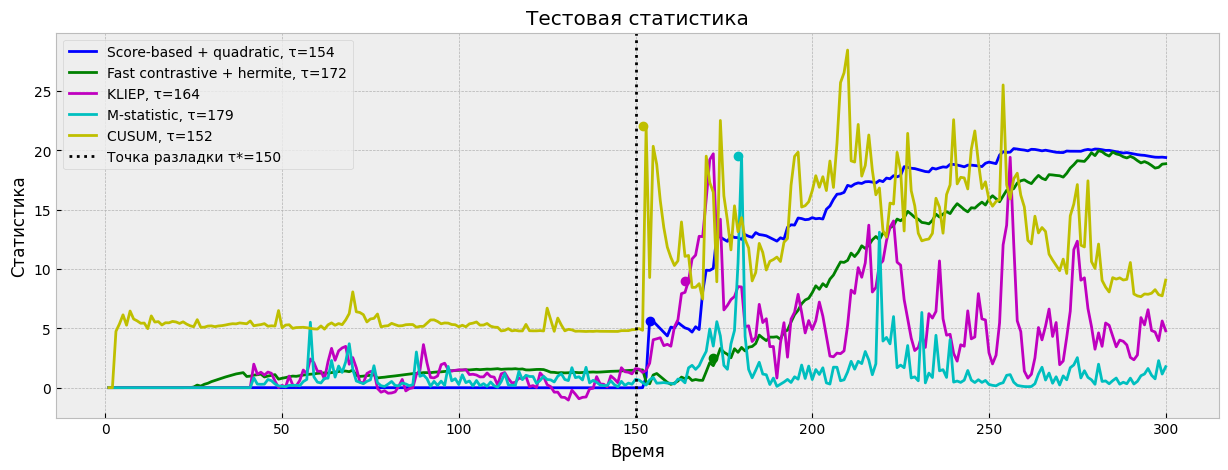

In [256]:
plt.figure(figsize=(15, 5))
plt.title('Тестовая статистика')
plt.xlabel('Время')
plt.ylabel('Статистика')
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("bmh")

for key, value in S_dict.items():
    plt.plot(time, value, label=f'{key}, τ={st_dict[key]}', color=c[key])

for key, value in st_dict.items():
    plt.plot([value], [S_dict[key][value]], 'o', color=c[key])


plt.axvline(tau, c='black', ls=':', label=f'Точка разладки τ*={tau}')
plt.legend()
plt.savefig('1d_std_stats.png')
plt.show()

### 3d

In [257]:
c = {'Score-based + linear': 'r', 'Score-based + quadratic': 'b', 'Fast contrastive + hermite': 'g', 'KLIEP': 'm', 'M-statistic': 'c'}
thrs = {'Score-based + linear': threshold_3d_linear_03_30, 'Score-based + quadratic': threshold_1d_quadratic_03, 'Fast contrastive + hermite': threshold_3d_ftal_03_1e4, 'KLIEP': threshold_3d_kliep_03_2, 'M-statistic': threshold_3d_mmd_03_4}

In [258]:
dim = 3
n = 300
tau = 150

sigma = 0.3
eta = 1 / np.sqrt(np.arange(n) + 1)
mean = np.zeros(dim)
cov = np.eye(dim)

S_dict = {}

np.random.seed(0)
X = sigma * randmn(mean, cov, size=n).reshape((n, dim, 1))
X[tau:] += 3*sigma


sigma = 0.3
mean = np.zeros(dim)
cov = np.eye(dim)
eta = 1 / np.sqrt(np.arange(n) + 1)

X = randmn(mean, cov, size=n) * sigma
X[tau:] += 3*sigma 


# score based linear+ref
model = ChangePointDetector(d_dim=dim, lambda_=30, alpha=5e-4, basis=PolyBasis(1, dim), reference_score=reference_score)
S_scorebased_lin, st_lin = model.run(X.reshape((n, dim, 1)), eta)
S_dict['Score-based + linear'] = S_scorebased_lin

# score based quadratic
model = ChangePointDetector(dim*2, lambda_= 5, alpha=5e-5, basis=PolyBasis(2, dim)) 
S_scorebased_q, st_q = model.run(X.reshape((n, dim, 1)), eta)
S_dict['Score-based + quadratic'] = S_scorebased_q

# X = X.flatten()
# FALCON + hermite
S_hermite, st_ftal = compute_test_stat_ftal(X, p=1, beta=0.0001, design='multivariate')
S_dict['Fast contrastive + hermite'] = S_hermite

# kliep, m-stat
S_kliep, st_kliep = compute_test_stat_kliep(X, window_size=20, sigma=2)
S_dict['KLIEP'] = S_kliep
S_mmd, st_mmd = compute_test_stat_mmd(X, window_size=20, sigma=4)
S_dict['M-statistic'] = S_mmd



In [259]:
st_dict = {}

# score based linear+ref
model = ChangePointDetector(d_dim=dim, lambda_=30, alpha=5e-4, basis=PolyBasis(1, dim), reference_score=reference_score, threshold=threshold_3d_linear_03_30)
_, st_lin = model.run(X.reshape((n, dim, 1)), eta)
st_dict['Score-based + linear'] = st_lin
# score based quadratic
model = ChangePointDetector(dim*2, lambda_= 5, alpha=5e-5, basis=PolyBasis(2, dim), threshold=threshold_3d_quadratic_03) 
_, st_q = model.run(X.reshape((n, dim, 1)), eta)
st_dict['Score-based + quadratic'] = st_q

# X = X.flatten()
# FALCON + hermite
_, st_ftal = compute_test_stat_ftal(X, p=1, beta=0.0001, design='multivariate', threshold=threshold_3d_ftal_03_1e4)
st_dict['Fast contrastive + hermite'] = st_ftal

# kliep, m-stat
_, st_kliep = compute_test_stat_kliep(X, window_size=20, sigma=2, threshold=threshold_3d_kliep_03_2)
st_dict['KLIEP'] = st_kliep
_, st_mmd = compute_test_stat_mmd(X, window_size=20, sigma=4, threshold=threshold_3d_mmd_03_4)
st_dict['M-statistic'] = st_mmd

In [260]:
print(st_dict)

{'Score-based + linear': 169, 'Score-based + quadratic': 153, 'Fast contrastive + hermite': 152, 'KLIEP': 154, 'M-statistic': 154}


In [261]:
df = pd.DataFrame(S_dict)
df.max()

Score-based + linear            0.235435
Score-based + quadratic       156.542681
Fast contrastive + hermite     94.523952
KLIEP                          12.019543
M-statistic                    60.372969
dtype: float64

In [262]:
time = np.arange(1, n+1)

In [263]:
S_dict['Score-based + linear'] *= 80
S_dict['Score-based + quadratic'] /= 8
S_dict['Fast contrastive + hermite'] /= 4
S_dict['KLIEP'] *= 2
S_dict['M-statistic'] /= 3

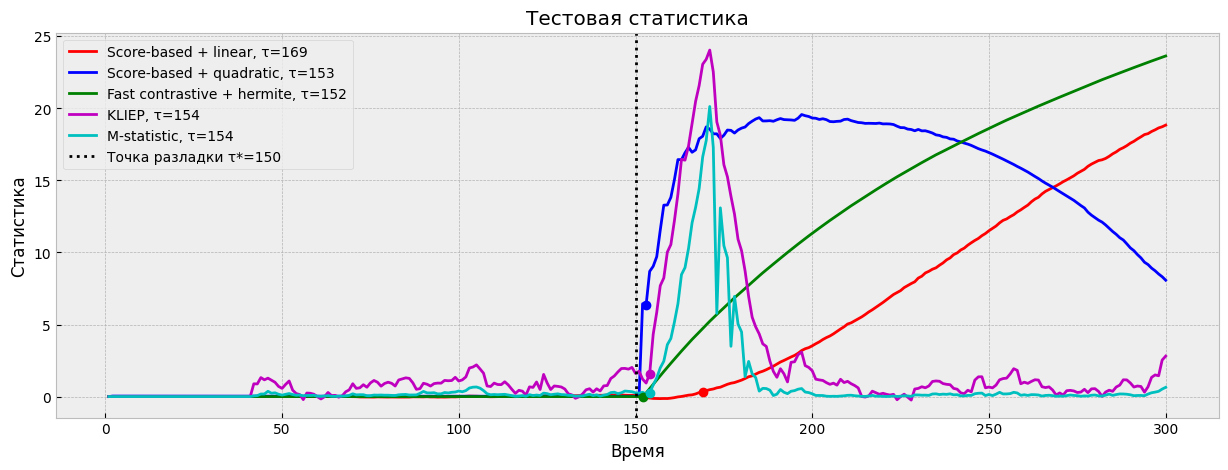

In [264]:
plt.figure(figsize=(15, 5))
plt.title('Тестовая статистика')
plt.xlabel('Время')
plt.ylabel('Статистика')
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("bmh")

for key, value in S_dict.items():
    plt.plot(time, value, label=f'{key}, τ={st_dict[key]}', color=c[key])

for key, value in st_dict.items():
    plt.plot([value], [S_dict[key][value-1]], 'o', color=c[key])


plt.axvline(tau, c='black', ls=':', label=f'Точка разладки τ*={tau}')
plt.legend()
plt.savefig('3d_mean_stats.png')
plt.show()

### std shift

In [265]:
dim = 3
n = 300
tau = 150

sigma = 0.3
eta = 1 / np.sqrt(np.arange(n) + 1)
mean = np.zeros(dim)
cov = np.eye(dim)

S_dict = {}

np.random.seed(0)
X = sigma * randmn(mean, cov, size=n).reshape((n, dim, 1))
X[tau:] += 3*sigma


sigma = 0.3
mean = np.zeros(dim)
cov = np.eye(dim)
eta = 1 / np.sqrt(np.arange(n) + 1)

X = randmn(mean, cov, size=n) * sigma
X[tau:] *= 3

# score based quadratic
model = ChangePointDetector(dim*2, lambda_= 5, alpha=5e-5, basis=PolyBasis(2, dim)) 
S_scorebased_q, st_q = model.run(X.reshape((n, dim, 1)), eta)
S_dict['Score-based + quadratic'] = S_scorebased_q

# X = X.flatten()
# FALCON + hermite
S_hermite, st_ftal = compute_test_stat_ftal(X, p=1, beta=0.0001, design='multivariate')
S_dict['Fast contrastive + hermite'] = S_hermite

# kliep, m-stat
S_kliep, st_kliep = compute_test_stat_kliep(X, window_size=20, sigma=2)
S_dict['KLIEP'] = S_kliep
S_mmd, st_mmd = compute_test_stat_mmd(X, window_size=20, sigma=4)
S_dict['M-statistic'] = S_mmd



In [266]:
st_dict = {}

# score based quadratic
model = ChangePointDetector(dim*2, lambda_= 5, alpha=5e-5, basis=PolyBasis(2, dim), threshold=threshold_3d_quadratic_03) 
_, st_q = model.run(X.reshape((n, dim, 1)), eta)
st_dict['Score-based + quadratic'] = st_q

# X = X.flatten()
# FALCON + hermite
_, st_ftal = compute_test_stat_ftal(X, p=1, beta=0.0001, design='multivariate', threshold=threshold_3d_ftal_03_1e4)
st_dict['Fast contrastive + hermite'] = st_ftal

# kliep, m-stat
_, st_kliep = compute_test_stat_kliep(X, window_size=20, sigma=2, threshold=threshold_3d_kliep_03_2)
st_dict['KLIEP'] = st_kliep
_, st_mmd = compute_test_stat_mmd(X, window_size=20, sigma=4, threshold=threshold_3d_mmd_03_4)
st_dict['M-statistic'] = st_mmd

In [267]:
time = np.arange(1, n+1)
df = pd.DataFrame(S_dict)
df.max()

Score-based + quadratic       475.203976
Fast contrastive + hermite      2.664317
KLIEP                          10.633671
M-statistic                     8.479018
dtype: float64

In [268]:
S_dict['Score-based + quadratic'] /= 50
S_dict['Fast contrastive + hermite'] *= 4
# S_dict['KLIEP'] *= 2
# S_dict['M-statistic'] /= 2

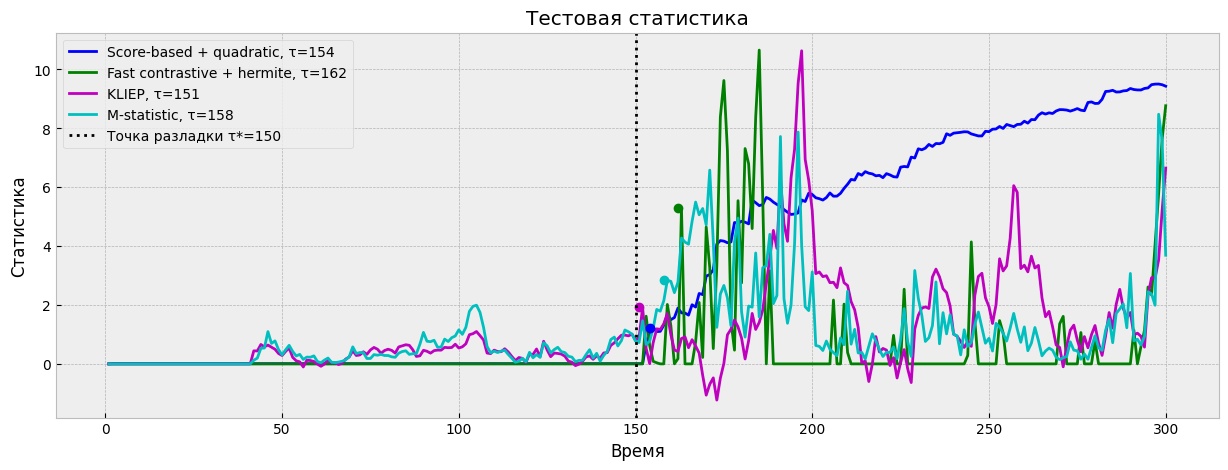

In [269]:
plt.figure(figsize=(15, 5))
plt.title('Тестовая статистика')
plt.xlabel('Время')
plt.ylabel('Статистика')
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("bmh")

for key, value in S_dict.items():
    plt.plot(time, value, label=f'{key}, τ={st_dict[key]}', color=c[key])

for key, value in st_dict.items():
    plt.plot([value], [S_dict[key][value]], 'o', color=c[key])


plt.axvline(tau, c='black', ls=':', label=f'Точка разладки τ*={tau}')
plt.legend()
plt.savefig('3d_std_stats.png')
plt.show()

In [270]:
print(st_dict)

{'Score-based + quadratic': 154, 'Fast contrastive + hermite': 162, 'KLIEP': 151, 'M-statistic': 158}
